# 11/21/22 Live Coding Demo 

# **Detecting sea level rise from Florida tide gauge records**
### Practice with Pandas time series analysis
<img src="https://drive.google.com/uc?export=view&id=1hSIOjtYu1jHM1sfi32KjCSwxi1ADybyR" width="1200" />

**Data description:** A netCDF file with hourly tide gauge records from Key West, FL (from 1913 to present). The tide gauge measurements are of relative sea level (RSL), which includes both sea level rise (from ice melt and thermal expansion) and local vertical land motion (from subsidence and isostatic rebound).

**Data source:** [University of Hawaii Sea Level Center](https://uhslc.soest.hawaii.edu/datainfo/)

In [1]:
# Import NumPy, xarray, Matplotlib
import numpy as np
import netCDF4
import pandas as pd
from scipy import interpolate, stats
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# **Smoothing Data** 

# Step 1: 
Open the Key West data file and convert the sea level record to a Pandas series. Display the new Pandas series.
Note: Drop the record id.

In [5]:
# read in the filepath 
filepath = "data/tide_gauge_key_west_fl.nc"

# open with xarray
key_west_xr = xr.open_dataset(filepath)
display(key_west_xr)

# data cleaning
key_west_xr = key_west_xr.drop('record_id').squeeze()

# make pandas series
key_west = key_west_xr.sea_level.to_pandas()
key_west.name = 'sea_level'
display(key_west)

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 944082)
Coordinates:
  * time                  (time) datetime64[ns] 1913-01-19T06:00:00 ... 2020-...
  * record_id             (record_id) int16 2420
Data variables:
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) |S12 ...
    station_country       (record_id) |S30 ...
    station_country_code  (record_id) float32 ...
    uhslc_id              (record_id) int16 ...
    gloss_id              (record_id) float32 ...
    ssc_id                (record_id) |S4 ...
    last_rq_date          (record_id) datetime64[ns] ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2020-11-24T14:42:15Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

time
1913-01-19 06:00:00.000000    1128.0
1913-01-19 07:00:00.028800    1128.0
1913-01-19 07:59:59.971200    1189.0
1913-01-19 09:00:00.000000    1250.0
1913-01-19 10:00:00.028800    1311.0
                               ...  
2020-09-30 19:00:00.028800    1829.0
2020-09-30 19:59:59.971200    1788.0
2020-09-30 21:00:00.000000    1786.0
2020-09-30 22:00:00.028800    1882.0
2020-09-30 22:59:59.971200    1968.0
Name: sea_level, Length: 944082, dtype: float32

# Step 2. Plot the time series from Key West.
- Consider using xlim and ylim to change the resolution of the plot by drilling down on a smaller timeframe (Ex: Eight months of tide gauge records from FL)





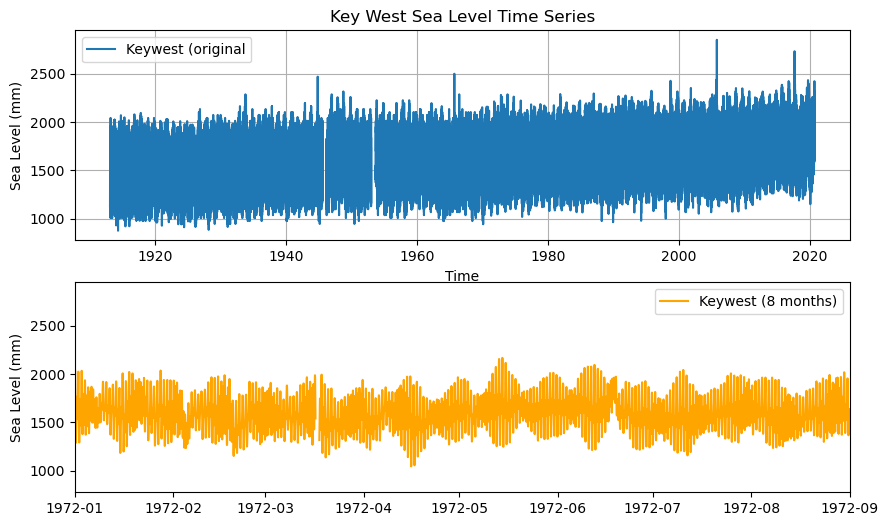

In [14]:
# make plot
fig, axs = plt.subplots(figsize=(10,6), nrows=2, sharex=False)
# first subplot (top) show the entire time series
axs[0].plot(key_west.index.values, key_west.values, label='Keywest (original')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Sea Level (mm)')
axs[0].grid()
axs[0].legend()
axs[0].set_title('Key West Sea Level Time Series')

# plot one subset (8 months)
axs[1].plot(key_west.index.values, key_west.values, 
            label='Keywest (8 months)', c='orange')
# random year
year = 1972
# set start and end dates for x-axis
axs[1].set_xlim([datetime(1972,1,1), datetime(1972, 9,1)])
axs[1].set_ylabel('Sea Level (mm)')
axs[1].legend()

# Step 3. Daily averages using `.resample()'


*   Calculate daily average of the time series using .resample().






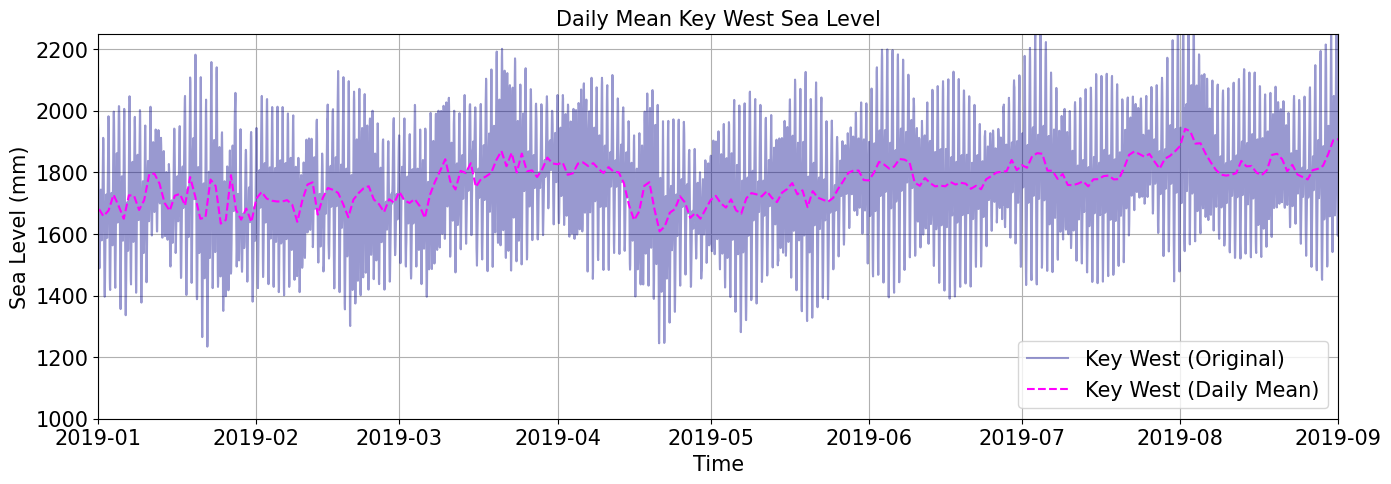

In [28]:
# resampling by day
key_west_daily = key_west.resample('D').mean()
#display(key_west_daily)

# plot
fig,axs = plt.subplots(figsize=(16,5))
# plot original time series
axs.plot(key_west.index.values, key_west.values, alpha=0.4, c='darkblue',
         label='Key West (Original)')
# plot resampled daily mean values
axs.plot(key_west_daily.index.values, key_west_daily.values, c='magenta',
         label='Key West (Daily Mean)', linestyle='--')
# subset by 8 months
axs.set_xlim([datetime(2019,1,1), datetime(2019, 9,1)])
# change y limits to visualize sea level better
axs.set_ylim([1000,2250])
# add a legend
axs.legend()
# add axis labels
axs.set_xlabel('Time')
axs.set_ylabel('Sea Level (mm)', size=15)
# add a title 
axs.set_title('Daily Mean Key West Sea Level', size=15)
axs.grid()
# hack to set fontsize for all text
plt.rcParams.update({'font.size': 15})

# Step 4. Monthly running means using `.rolling()`


* Calculate monthly running mean of the hourly time series using .rolling().

* Save these as two new variables. Display one of them to check that it worked.

* Make a new plot using the monthly rolling values



/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


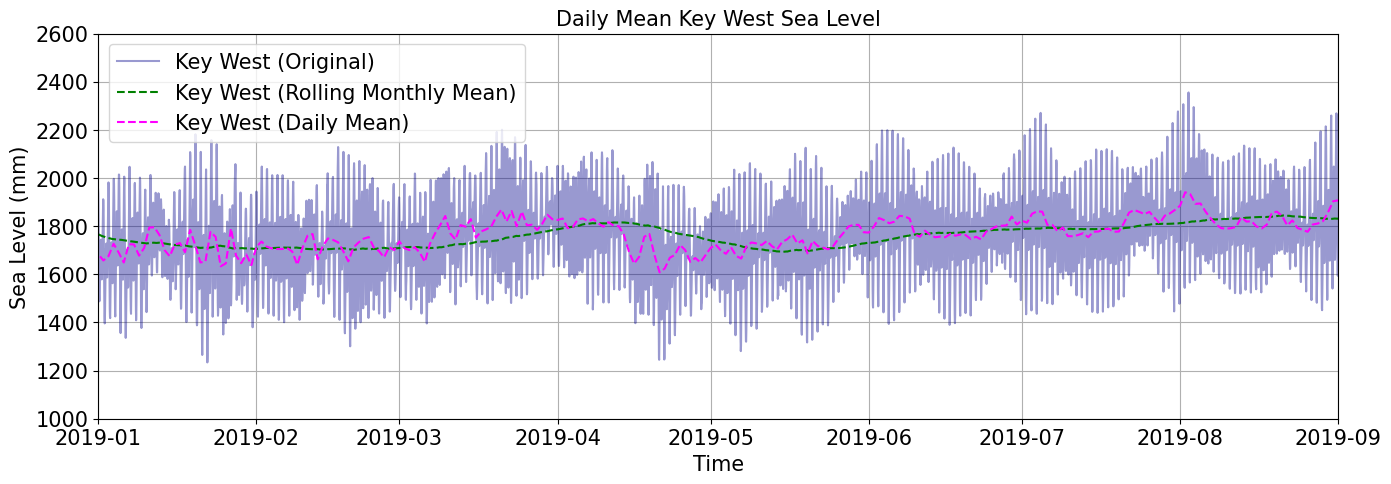

In [33]:
# calculate rolling monthly mean
key_west_monthly = key_west.rolling(window=24*30, min_periods=24).mean()

# plot
fig,axs = plt.subplots(figsize=(16,5))
# plot original time series
axs.plot(key_west.index.values, key_west.values, alpha=0.4, c='darkblue',
         label='Key West (Original)')
# plot montly rolling mean values
axs.plot(key_west_monthly.index.values, key_west_monthly.values, c='green',
         label='Key West (Rolling Monthly Mean)', linestyle='--')
# plot resampled daily mean values
axs.plot(key_west_daily.index.values, key_west_daily.values, c='magenta',
         label='Key West (Daily Mean)', linestyle='--')
# subset by 8 months
axs.set_xlim([datetime(2019,1,1), datetime(2019, 9,1)])
# change y limits to visualize sea level better
axs.set_ylim([1000,2600])
# add a legend
axs.legend()
# add axis labels
axs.set_xlabel('Time')
axs.set_ylabel('Sea Level (mm)', size=15)
# add a title 
axs.set_title('Daily Mean Key West Sea Level', size=15)
axs.grid()
# hack to set fontsize for all text
plt.rcParams.update({'font.size': 15})

# **Interpolating**

# Step 1:

* Load the NASA_GISS_global_temp CSV using pandas 
Note: Set your index_col to 'Year'

In [34]:
# get filepath to temperature dataset
filepath = "data/NASA_GISS_global_temp.csv"

# load dataframe with index set to 'Year'
global_temp = pd.read_csv(filepath, index_col='Year')
display(global_temp)

,Temp_anomaly,Temp_anomaly_smooth
Year,,
1880,-0.16,-0.08
1881,-0.07,-0.12
1882,-0.10,-0.16
1883,-0.16,-0.19
1884,-0.27,-0.23
...,...,...
2015,0.90,0.83
2016,1.01,0.87
2017,0.92,0.91


# Step 2:
* Create a line plot of the years vs temperature anomaly. 


Text(0.5, 1.0, 'Years vs. Temperature Anomaly')

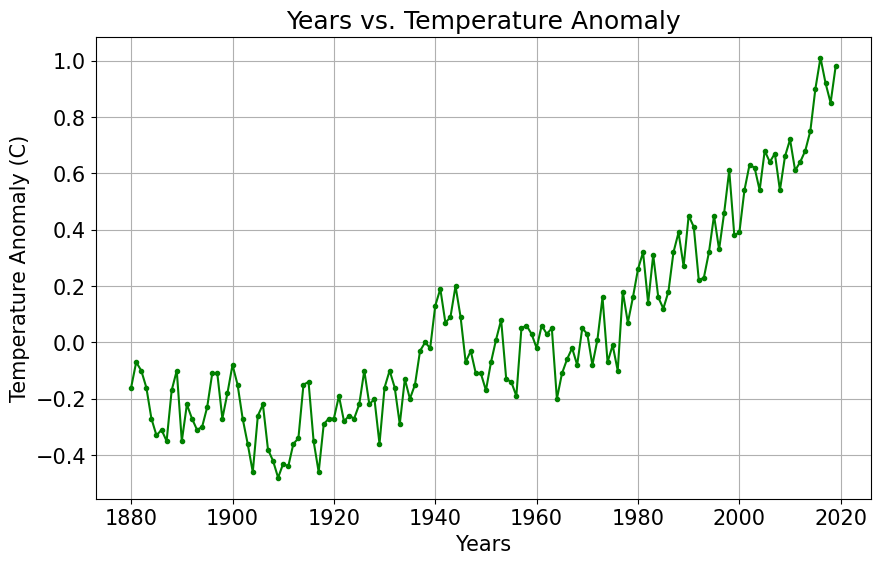

In [38]:
#  Make a black solid line plot of the original 1880-2019 time series in "global_temp".
#    Add a grid and axis labels.
fig,axs = plt.subplots(figsize=(10,6))
axs.plot(global_temp.index, global_temp['Temp_anomaly'], c='green',
        label='Original Time Series', marker='.')
axs.grid()
axs.set_xlabel('Years')
axs.set_ylabel('Temperature Anomaly (C)')
axs.set_title('Years vs. Temperature Anomaly')

# Step 3: Removing a portion of data 
* Recreate the original line plot
* Create a copy of "global_temp" and save it as a new variable, "gt_missing_1990s"
* Drop the 1990s data from the new copy
* Add scatter points for the incomplete time series in "gt_missing_1990s"


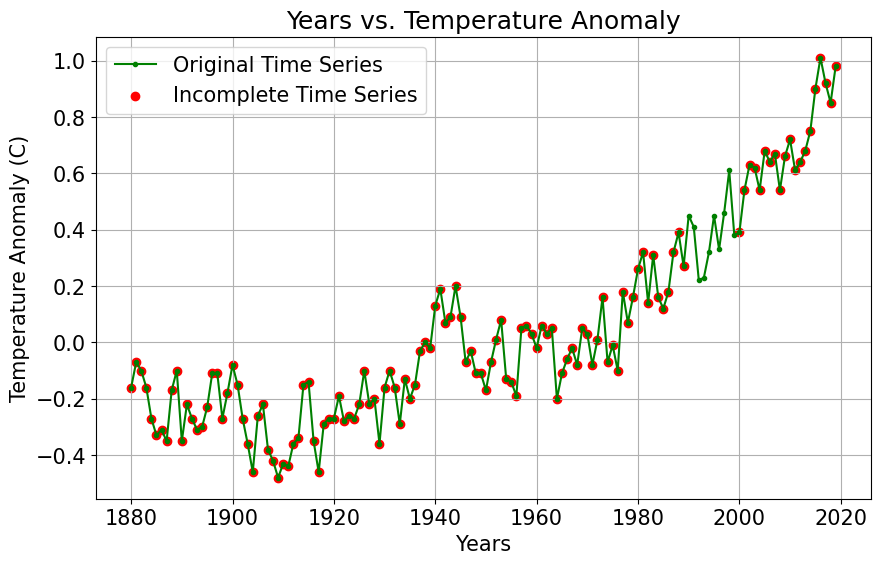

In [42]:
# copy over plot
fig,axs = plt.subplots(figsize=(10,6))
axs.plot(global_temp.index, global_temp['Temp_anomaly'], c='green',
        label='Original Time Series', marker='.')
axs.grid()
axs.set_xlabel('Years')
axs.set_ylabel('Temperature Anomaly (C)')
axs.set_title('Years vs. Temperature Anomaly')

# make copy of data
gt_missing_1990s = global_temp.copy()

# Delete years 1990-1999 from dataframe copy
years_missing = range(1990,2000)
gt_missing_1990s = gt_missing_1990s.drop(years_missing)

# On the same plot, add red scatter points for the incomplete time series in "gt_missing_1990s".
plt.scatter(gt_missing_1990s.index, gt_missing_1990s['Temp_anomaly'],
            color='red', label='Incomplete Time Series')

# Add label arguments to your plot functions above, then add a legend.
plt.legend()

# Step 4: Interpolate over the missing data
* Use SciPy's interp1d() to linearly interpolate the data in "gt_missing_1990s" to the missing years, which are stored in the variable "years_missing_1990s".
* On the same plot, add scatter points for the temperatures interpolated to years in "years_missing_1990s".

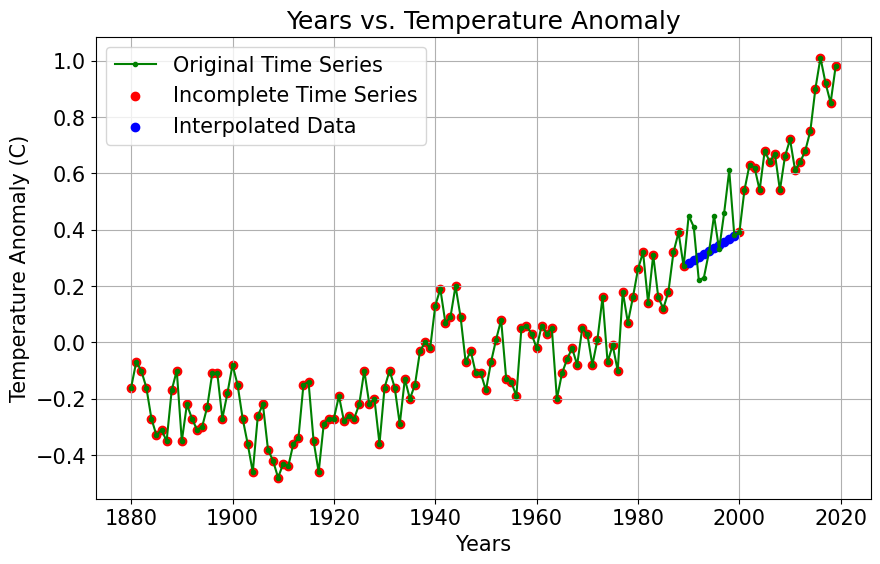

In [46]:
# Copy/paste plot from step 3
# copy over plot
fig,axs = plt.subplots(figsize=(10,6))
axs.plot(global_temp.index, global_temp['Temp_anomaly'], c='green',
        label='Original Time Series', marker='.')
axs.grid()
axs.set_xlabel('Years')
axs.set_ylabel('Temperature Anomaly (C)')
axs.set_title('Years vs. Temperature Anomaly')

# make copy of data
gt_missing_1990s = global_temp.copy()

# Delete years 1990-1999 from dataframe copy
years_missing = range(1990,2000)
gt_missing_1990s = gt_missing_1990s.drop(years_missing)

# On the same plot, add red scatter points for the incomplete time series in "gt_missing_1990s".
plt.scatter(gt_missing_1990s.index, gt_missing_1990s['Temp_anomaly'],
            color='red', label='Incomplete Time Series')


# Use SciPy's interp1d() to linearly interpolate the data
interp_func = interpolate.interp1d(gt_missing_1990s.index,
                                  gt_missing_1990s['Temp_anomaly'], 
                                  kind='linear',
                                  bounds_error = False)
# apply interpolation to our incomplete time series
gt_new_1990s=interp_func(years_missing)

# add to plot
plt.scatter(years_missing, gt_new_1990s, c='blue', 
            label='Interpolated Data')
#Add label arguments to your plot functions above, then add a legend.
plt.legend()

# Step 5: Run linear regression over data (if time permits)
* Use scipy.stats linregress() to calculate the linear regression of temperature over all yearsm

In [ ]:
# copy/paste plot from step 4
...

# calculate linear regression
...

# add to plot